In [153]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")
include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")
using Distributions, Plots, KernelDensity, DataFrames

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


In [154]:
n = 100
t_pt_sample_dens = 30;

In [155]:
# don't change
t_fixed = true
t_end = 100.0
#M = Int(t_end * 10) # plot M points
#t_pt_sample_dens = t_pt_sample_dens  * 10; Q: warum hatte ich das gemacht, ist irgendwie falsch? bzw eher unnötig?

100.0

### Tools

In [156]:
# copied from sa on prior/post notebook
"""
    function plot_prob_traj(times::Vector{Float64}, n_traj_sampled::Vector{Any}, w_traj_sampled::Vector{Any}, data_true::DataFrame, prm::String)

Plot probabilistic trajectories of model simulations. Black line indicates true, noiseless solution.

# Args:
    - `times::Vector{Float64}"`: considered time points of solution
    - `n_traj_sampled::Vector{Any}`: each item is vector of one sampled trajectory of n
    - `w_traj_sampled::Vector{Any}`: each item is vector of one sampled trajectory of w
    - `data_true::DataFrame`: output of sol_klausmeier for true parameter values (not noisy!)
    - `prm::String`: name of the parameter sampled to create trajectory samples
"""
function plot_prob_traj(times::Vector{Float64}, n_traj_sampled::Vector{Any}, w_traj_sampled::Vector{Any}, data_true::DataFrame, prm::String)
    n_mean = mean(n_traj_sampled, dims=1)
    w_mean = mean(w_traj_sampled, dims=1)

    n = length(n_traj_sampled)

    plot_traj = plot(times, n_mean, label="mean n", lw=2, color=:blue, legend=:bottomright, title="Model outputs under variation of $prm")
    plot!(times, w_mean, label="mean w", lw=2, color=:orange)
    for i in range(1, n)
        plot!(times,n_traj_sampled[i], color=:blue, alpha=0.05, label="")
        plot!(times,w_traj_sampled[i], color=:orange, alpha=0.05,label="")
    end
    plot!(times, data_true[!,"n"], lw=2, color=:black, label="",linestyle=:dash)
    plot!(times, data_true[!,"w"], lw=2, color=:black, label="", linestyle=:dash)
    return plot_traj
end

"""
    function plot_sample_dens_t(t_pt_sample_dens::Int64, n_traj_sampled::Vector{Any}, w_traj_sampled::Vector{Any}, n_t_true::Float64, w_t_true::Float64, prm::String)

Plots the sample density of the trajectories at specified time point. Vertical lines indicate true values of noiseless solution at t_pt_sample_dens.

# Args:
    - `t_pt_sample_dens::Int64`: time point at which sample density is computed
    - `n_traj_sampled::Vector{Any}`: each item is vector of one sampled trajectory of n
    - `w_traj_sampled::Vector{Any}`: each item is vector of one sampled trajectory of w
    - `n_t_true::Float64`: true value at time point of n trajectory (not noisy!)
    - `w_t_true::Float64`: true value at time point of w trajectory (not noisy!)
    - `prm::String`: name of the parameter sampled to create trajectory samples
"""        
function plot_sample_dens_t(t_pt_sample_dens::Int64, n_traj_sampled::Vector{Any}, w_traj_sampled::Vector{Any}, n_t_true::Float64, w_t_true::Float64, prm::String)
    n_t_sam, w_t_sam = [s[t_pt_sample_dens] for s in n_traj_sampled], [s[t_pt_sample_dens] for s in w_traj_sampled]
    n_t_dens, w_t_dens = kde(n_t_sam), kde(w_t_sam)
    plot_m_dens = plot(n_t_dens.x, n_t_dens.density, color=:blue, lw=2, label="n", title="Sample densities under variation of $prm")
    plot!(w_t_dens.x, w_t_dens.density, color=:orange, lw=2, label="w")
    vline!([n_t_true], color=:black, linestyle=:dash, label=""), vline!([w_t_true], color=:black, linestyle=:dash, label="")
    return plot_m_dens
end

plot_sample_dens_t

### LEFT

In [157]:
# create true data trajectories
w0 = 0.95
n0 = 1.5
a = 0.3
m = 0.45
M = 100

hprm = Src.Hyperprm(w0,n0,a,m,M,0.0)
data_true = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end=t_end) # non-noisy data
data_obs = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end=t_end) # noisy data
data_obs = Src.randomize_data!(data_obs, noise)
times = data_true[!,"time"]

# true values at t_pt_sample_dens
n_t_true, w_t_true = data_true[!,"n"][t_pt_sample_dens], data_true[!,"w"][t_pt_sample_dens];

#### noise 0.01

In [158]:
noise = 0.01;

For now: manually extract MLEs for a, m from inverse uq notebook

In [159]:
mle = [0.3011294959350269, 0.4521741218077887]
cov = [0.000105457  3.47582e-5; 3.47582e-5   0.000287127]
posterior = MvNormal(mle, cov)

FullNormal(
dim: 2
μ: [0.3011294959350269, 0.4521741218077887]
Σ: [0.000105457 3.47582e-5; 3.47582e-5 0.000287127]
)


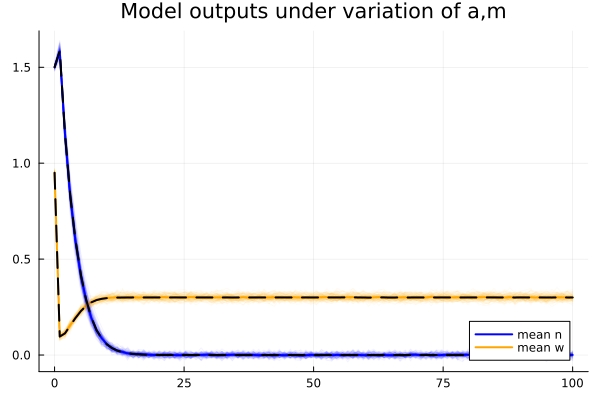

In [160]:
# sample
samples = rand(posterior, n)

# store for plotting
n_traj_sampled = []
w_traj_sampled = []

# for each sample solve klausmeier model
for i in 1:size(samples,2)
    s = samples[:,i]
    hprm = Src.Hyperprm(w0,n0,s[1],s[2],M,noise)
    sol = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end = t_end)
    sol = Src.randomize_data!(sol, hprm.noise)
    push!(n_traj_sampled, sol[!,"n"])
    push!(w_traj_sampled, sol[!,"w"])
end

# plot probabilistic solution trajectories
plot_prob_traj(times, n_traj_sampled, w_traj_sampled, data_true, "a,m")

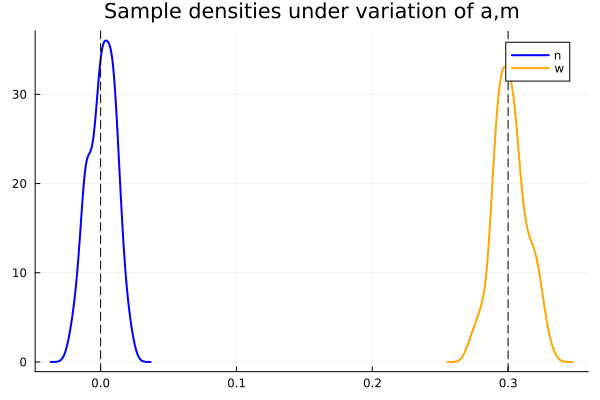

In [161]:
plot_sample_dens_t(t_pt_sample_dens, n_traj_sampled, w_traj_sampled, n_t_true, w_t_true, "a,m")

#### noise = 0.1

In [162]:
noise = 0.1;

For now: manually extract MLEs for a, m from inverse uq notebook

In [163]:
mle = [0.304974693418045, 0.4454823320707919]

2-element Vector{Float64}:
 0.304974693418045
 0.4454823320707919

Fisher inversion: Use inverse of Fisher Information Matrix as approximation of covariance matrix

In [164]:
cov = [0.00105569  0.00035361; 0.00035361  0.00294412]

2×2 Matrix{Float64}:
 0.00105569  0.00035361
 0.00035361  0.00294412

In [165]:
posterior = MvNormal(mle, cov)

FullNormal(
dim: 2
μ: [0.304974693418045, 0.4454823320707919]
Σ: [0.00105569 0.00035361; 0.00035361 0.00294412]
)


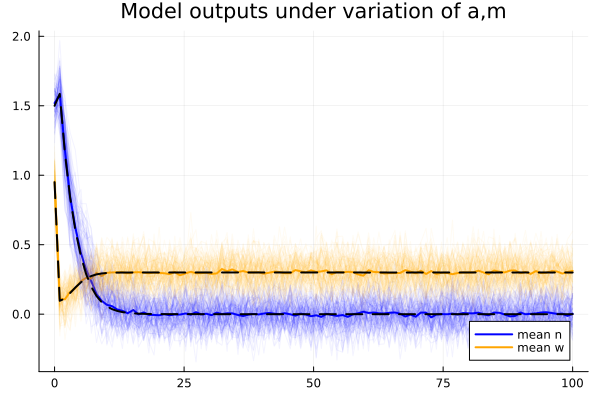

In [166]:
# sample
samples = rand(posterior, n)

# store for plotting
n_traj_sampled = []
w_traj_sampled = []

# for each sample solve klausmeier model
for i in 1:size(samples,2)
    s = samples[:,i]
    hprm = Src.Hyperprm(w0,n0,s[1],s[2],M,noise)
    sol = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end = t_end)
    sol = Src.randomize_data!(sol, hprm.noise)
    push!(n_traj_sampled, sol[!,"n"])
    push!(w_traj_sampled, sol[!,"w"])
end

# plot probabilistic solution trajectories
plot_prob_traj(times, n_traj_sampled, w_traj_sampled, data_true, "a,m")

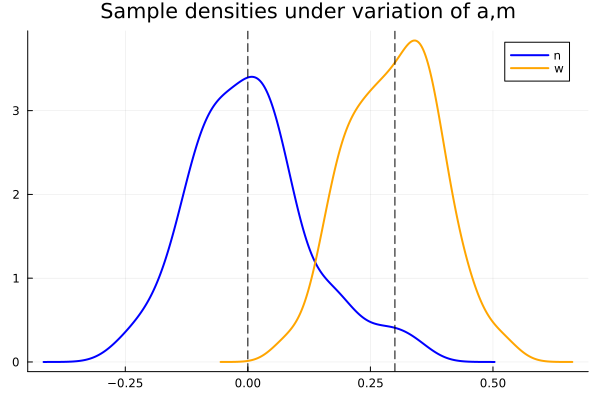

In [167]:
plot_sample_dens_t(t_pt_sample_dens, n_traj_sampled, w_traj_sampled, n_t_true, w_t_true, "a,m")

#### noise 0.5

In [168]:
noise = 0.5;

In [169]:
mle = [0.3200212607414804, 0.5289705752648506]
cov = [0.00524214  0.0015298; 0.0015298   0.017724]
posterior = MvNormal(mle, cov)

FullNormal(
dim: 2
μ: [0.3200212607414804, 0.5289705752648506]
Σ: [0.00524214 0.0015298; 0.0015298 0.017724]
)


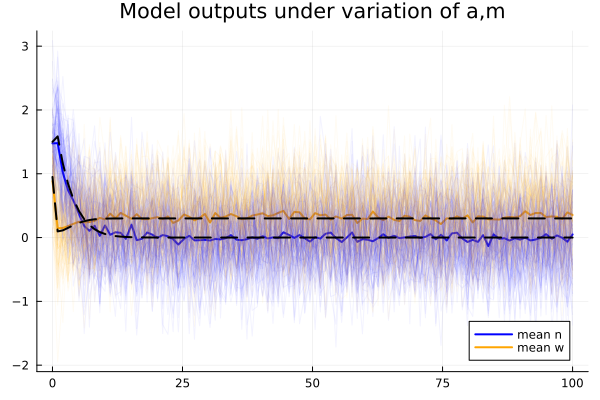

In [170]:
# sample
samples = rand(posterior, n)

# store for plotting
n_traj_sampled = []
w_traj_sampled = []

# for each sample solve klausmeier model
for i in 1:size(samples,2)
    s = samples[:,i]
    hprm = Src.Hyperprm(w0,n0,s[1],s[2],M,noise)
    sol = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end = t_end)
    sol = Src.randomize_data!(sol, hprm.noise)
    push!(n_traj_sampled, sol[!,"n"])
    push!(w_traj_sampled, sol[!,"w"])
end

# plot probabilistic solution trajectories
plot_prob_traj(times, n_traj_sampled, w_traj_sampled, data_true, "a,m")

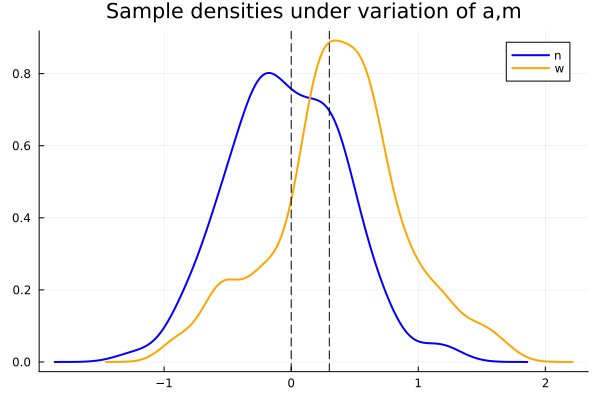

In [171]:
plot_sample_dens_t(t_pt_sample_dens, n_traj_sampled, w_traj_sampled, n_t_true, w_t_true, "a,m")

#### Probabilistic bifurcation diagram

In [ ]:
upper_branches = []
lower_branches = []

for i in 1:size(samples,2)
    a,m = samples[:,i]
    up = 
end

0.35738596475493023

0.5733828427448318

0.27904107765818625

0.6577585396250275

0.3156206448456707

0.6380159229440511

0.2858040834494766

0.28769011054897076

0.3929980192885004

0.475525044931091

0.19972019886487813

0.6013857323662627

0.13783547366251023

0.47805446056553097

0.365961272868227

0.5215331784644085

0.3534418356849588

0.44649237212486653

0.4439196527027623

0.826007749671923

0.23626273524629135

0.2621104981161723

0.2645897505105009

0.31353437536729645

0.2672212760808273

0.5184076029567531

0.21141610701329766

0.7284890735003965

0.32132362888488053

0.42923101028714233

0.227957522644577

0.6215697919744

0.27388733951111666

0.8216113472859072

0.2706259950354102

0.6518181672279486

0.44873347341834074

0.5393380747134792

0.41731408587625446

0.5867382970718908

0.26611060433206823

0.43666514141817736

0.30311364115099826

0.4618851168724054

0.25751270324368053

0.5422437825244528

0.2055506847054886

0.6118901727933292

0.250065759032678

0.46667975008232265

0.25263426419968416

0.23602912886224842

0.2910364761820409

0.498271581352849

0.3492254650910445

0.5347997268791163

0.2638081140776249

0.4418838868913043

0.17639607759250414

0.6159039405579715

0.36372694100760206

0.7022452967142336

0.23809383874307427

0.5050148095127123

0.2946266703756296

0.2691066358390294

0.34193707455897077

0.33440886143172066

0.35699953212479607

0.3594384680448829

0.5226299572413721

0.42046447377032836

0.2791922313751695

0.4071374597620978

0.3284220089111253

0.48596852789727185

0.3832412101252643

0.3901342025053856

0.35260871801381055

0.580608406641187

0.3664668651220566

0.3202117738569362

0.3498889400248791

0.3281437638263251

0.22372166671645857

0.5050310150786896

0.29291133926492047

0.5515811231180787

0.23429097686020722

0.7051298803075913

0.22199294131234676

0.5212973712042079

0.362632614165195

0.5588507735098406

0.329457583065852

0.2682866477393116

0.34882564174398667

0.42511330631160027

0.23462704130013207

0.36218794659543085

0.36526449476965284

0.5926160690111831

0.2730294174868104

0.4834240666599211

0.37862681661602826

0.5502961281026891

0.20378503101306755

0.4717201731842115

0.3458047720372775

0.6533552903677583

0.2263161301085425

0.6374878377144513

0.1802072220773975

0.4845020640011155

0.2592153303742126

0.5485614540123526

0.43009077583485883

0.6672358717694322

0.31461814023425533

0.7151768638804935

0.18866416651659929

0.45673500559436936

0.29166595231023057

0.3472003577829347

0.39813529310163964

0.5886167132254279

0.4209810680024728

0.5295579016806012

0.20066204344141175

0.3347753931330207

0.3303743554591016

0.7705211914129896

0.3512984217419192

0.403274833337538

0.4039675052803648

0.5943404511703303

0.340195989671839

0.6251851614484977

0.49473678896241086

0.3300247429974464

0.4231969371764889

0.5678250903502886

0.334068055799326

0.48782937379525965

0.35025046001246257

0.47174732941509184

0.1882781395031914

0.6172663572898136

0.3516023359854193

0.5484072745038104

0.3564871549787977

0.5330479673030151

0.3541173669621812

0.7445869045861913

0.23713394242890048

0.5351345311508588

0.4456623095358293

0.47708922018887023

0.5076963294279323

0.6779229174226233

0.4797075131659757

0.5866050428344002

0.3802709509123761

0.586664851651583

0.30099762463281104

0.5846309961330539

0.30434575312445294

0.6224558102331008

0.4022204930201405

0.5526153395391687

0.28729526261139543

0.5279290993504194

0.25952114680542143

0.47138520552262103

0.43499610515099996

0.43854654076413024

0.3903664624853259

0.5179758304552278

0.3641443843015784

0.676804235355769

0.20599586830287273

0.5454881406980584

0.4284601937467272

0.35240217865362566

0.4100219538437527

0.4749027918519797

0.32200909413802054

0.5566839182450305

0.36248353838864966

0.47074338314284453

0.17243879224001285

0.5741497858265072

0.45936036683111103

0.7315958823687061

0.4053886370603419

0.6501583440713462

0.22935146151951868

0.5766983654604234

0.35243982238044147

0.5920568012954897